# Using Census APIs for Equity Analysis

This workshop will demonstrate how to use US Decennial Census and American Community Survey Data (ACS) Application Programming Interfaces (APIs). We will use these basic operations in order to calculate and map poverty rates in New York State. (A similiar script can be applied to calculate ethnicity, gender, mobility, and journey to work, but will not be covered here).  We will pull data from the [ACS 5-year estimates for 2020](https://www.census.gov/data/developers/data-sets/acs-5year.html) for this workshop.

Prerequisites:
1. Anaconda 3 installed
2. Knowledge of Jupyter Notebook
3. Knowledge of Python
4. Knowledge of how to install GeoPandas
5. Knowledge of how to perform pip installations

NOTE:  The cool thing about using APIs is, once this script is developed, the data should remain current with each use--no need to update the links to the API!

## Step 1: Import the modules you will need

If you don't have geopandas installed, then the code below will not run:

For help, try this article: ["Fastest way to install Geopandas in jupyter notebook on Windows"](https://medium.com/analytics-vidhya/fastest-way-to-install-geopandas-in-jupyter-notebook-on-windows-8f734e11fa2b), by Tanish Gupta

If that doesn't work, then try installing python 3.9 and creating a new virtual environment in the Anaconda prompt:

1. Type in “<span style="color:red">conda create –name py39 python=3.9</span>” in the Anaconda Prompt and hit enter. Py39 is the virtual environment name. 
2. If that works, then type in “<span style="color:red">activate py39</span>” and press Enter. 
3. Then type in “<span style="color:red">conda install geopandas</span>” and hit enter. 

Also, you will need to perform a pip install for <span style="color:red">census</span>, <span style="color:red">us</span>, and <span style="color:red">PyGithub</span> to use those libraries

And make sure you have the latest shapely library installed.  If not, you will need to upgrade it (<span style="color:red">conda install shapely</span>)

In [1]:
#import modules
import matplotlib.pyplot as plt # plotting tool
import pandas as pd # data analysis and manipulation tool
import geopandas as gpd # extends the datatypes used by pandas to allow spatial operations on geometric types
from shapely.geometry import Polygon # for geometric operations
from census import Census # library for accessing census tables
from us import states # library for accessing the FIPS codes for many geographies
import fiona # for file access 
import base64 # provides functions for encoding/decoding binary data to printable ASCII
from github.MainClass import Github, GithubIntegration # main class to access the Github API v3
from github.InputGitTreeElement import InputGitTreeElement # This class represents InputGitTreeElements(path, mode, type, content, sha)
import os #  provides functions for interacting with the underlying operating system

In [2]:
# You can ignore this, but if you want to see a list of all spatial data types that are supported, just remove the hashtag
# fiona.supported_drivers

In [3]:
# pip install PyGithub

In [4]:
# pip install census

In [5]:
# pip install us

## Step 2: Import data from Census

Importing data from the Census APIs into Python requires a [Census API key](http://api.census.gov/data/key_signup.html).  It will provide you with a unique 40 digit text string. <u><i><b>Please keep track of this number</b></i></u>.   The [Census API User Guide](https://www.census.gov/content/dam/Census/data/developers/api-user-guide/api-guide.pdf) can give you some more information on how to use this API to query the data.

You can register for an API key, free of charge by following these steps:
1. Go to the [Census API key](http://api.census.gov/data/key_signup.html) site
2. Fill out the pop-up window form.
4. You will receive an email with your key code in the message and a link to register it.

### <span style="color:green">NOTE: Keep your API key private!  I used mine to test my script, but I've removed it from below.</span>

In [6]:
# Set API key
c = Census("Enter your 40 digit text string here")

Now access the census data at the tract level for New York State from the 2020 ACS.  The tables you are looking for are the ratio of income to poverty in the past 12 months <b>(C17002_001E, total; C17002_002E, < 0.50; and C17002_003E, 0.50 - 0.99)</b> variables and total population <b>(B01003_001E)</b>. For more information on why these variables are used, refer to the US Census Bureau’s article on [How the Census Bureau measures poverty](https://www.census.gov/topics/income-poverty/poverty/guidance/poverty-measures.html) and [the 2020 list of variables found in ACS](https://api.census.gov/data/2020/acs/acs5/variables.html).

The <span style="color:red">census</span> package provides us with methods to obtain geographic data through an FIPS code (36 for New York).  We can also use the <span style="color:red">us</span> library to help us figure out the relevant FIPS code if we want to analyze other geographies.  Note that we are using the 2020 ACS to access data from 2019.

In [7]:
# Obtain Census variables from the 2020 ACS at the tract level for the State of New York (FIPS code: 36)
# C17002_001E: count of ratio of income to poverty in the past 12 months (total)
# C17002_002E: count of ratio of income to poverty in the past 12 months (< 0.50)
# C17002_003E: count of ratio of income to poverty in the past 12 months (0.50 - 0.99)
# B01003_001E: total population
# Sources: https://api.census.gov/data/2020/acs/acs5/variables.html; https://pypi.org/project/census/
ny_census = c.acs5.state_county_tract(fields = ('NAME', 'C17002_001E', 'C17002_002E', 'C17002_003E', 'B01003_001E'),
                                      state_fips = states.NY.fips,
                                      county_fips = "*",
                                      tract = "*",
                                      year = 2019)

Now that we have accessed the data and assigned it to a variable, we can read the data into a dataframe using the pandas library.  This is NOT the geodataframe.  That comes later.

In [8]:
# Create a dataframe from the census data
ny_df = pd.DataFrame(ny_census)

# Show the dataframe
print(ny_df.head(5))
print('Shape: ', ny_df.shape)

                                             NAME  C17002_001E  C17002_002E  \
0      Census Tract 55, Onondaga County, New York       3542.0        912.0   
1   Census Tract 56.01, Onondaga County, New York       1569.0         71.0   
2   Census Tract 61.02, Onondaga County, New York       1842.0        253.0   
3  Census Tract 112.01, Onondaga County, New York       3844.0        147.0   
4   Census Tract 56.02, Onondaga County, New York        198.0         76.0   

   C17002_003E  B01003_001E state county   tract  
0        400.0       3563.0    36    067  005500  
1         46.0       1599.0    36    067  005601  
2        336.0       1842.0    36    067  006102  
3        249.0       3844.0    36    067  011201  
4         68.0       3950.0    36    067  005602  
Shape:  (4918, 8)


### By showing the dataframe, we can see that there are 4918 rows (i.e. 4918 census tracts) and 8 columns.


## Step 3: Import Shapefile

Let’s also read into Python a 2019 shapefile (so that the number of rows match) of the New York census tracts.  This shapefile can be downloaded on the Census Bureau’s website on the [Cartographic Boundary Files page](https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html) or the [TIGER/Line Shapefiles page](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html).)  However, we are just going to access it from where it lives on the web. 

We're also going to reproject the spatial data into the UTM Zone 18N (also known as EPSG 32618) projection (because this will allow us to project the entire state of New York, instead of just a particular section). 

After that, it's time to create a geodataframe to hold this data.  To make sure we've done this right, you're going to print the headers and the first 5 rows, as well as the data projection, as the output of this cell.

In [9]:
# Access shapefile of New York census tracts
ny_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_36_tract.zip")

# Reproject shapefile to UTM Zone 18N
# https://spatialreference.org/ref/epsg/wgs-84-utm-zone-18n/
ny_tract = ny_tract.to_crs(epsg = 32618)

# Print GeoDataFrame of shapefile
print(ny_tract.head(5))
print('Shape: ', ny_tract.shape)

# Check shapefile projection
print("\nThe shapefile projection is: {}".format(ny_tract.crs))

  STATEFP COUNTYFP TRACTCE        GEOID NAME          NAMELSAD  MTFCC  \
0      36      081  044800  36081044800  448  Census Tract 448  G5020   
1      36      081  045800  36081045800  458  Census Tract 458  G5020   
2      36      081  046200  36081046200  462  Census Tract 462  G5020   
3      36      081  046300  36081046300  463  Census Tract 463  G5020   
4      36      081  046400  36081046400  464  Census Tract 464  G5020   

  FUNCSTAT   ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  208002       0  +40.7110219  -073.8026344   
1        S  245281       0  +40.7152626  -073.7909261   
2        S  249611       0  +40.7098547  -073.7879749   
3        S  159415       0  +40.7440007  -073.8710900   
4        S  228767       0  +40.7168637  -073.7869958   

                                            geometry  
0  POLYGON ((600815.465 4507478.308, 600891.234 4...  
1  POLYGON ((601895.758 4507688.811, 601896.787 4...  
2  POLYGON ((602035.695 4507385.405, 602120.876 4... 

We can see that the shapefile also has 4918 rows (4918 tracts). This number matches with the number of census records that we have on file, which means we are using the correct file and will have a one-to-one match for our rows (hopefully).

Right now the census data and the census tracts that correspond with that data are stored in two separate variables (<span style="color:red">ny_df</span> and <span style="color:red">ny_tract</span>). That makes it a bit difficult to map since these two separate datasets aren’t connected to each other.  That means our next task will be to join the two datasets together.


## Step 4: Create new column from old columns to get combined FIPS code

We can join the two dataframes together via a field or column that is common to both dataframes, which is referred to as a key.

Looking at the two datasets above, it appears that the GEOID column from ny_tract and the state, county, and tract columns combined from ny_df could serve as the unique key for joining these two dataframes together. In their current forms, this join will not be successful, as we’ll need to merge the state, county, and tract columns from ny_df together to make it parallel to the GEOID column from ny_tract. We can simply add the columns together, much like math or the basic operators in Python, and assign the “sum” to a new column.

To create a new column–or call an existing column in a dataframe–we can use indexing with <b>[]</b> and the column name (string). You can also access columns using the index number (which we are not doing here), but you can read more about indexing and selecting data [in the pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html).)

In [10]:
# Combine state, county, and tract columns together to create a new string and assign to new column
ny_df["GEOID"] = ny_df["state"] + ny_df["county"] + ny_df["tract"]

Printing out the first rew rows of the dataframe, we can see that the new column GEOID has been created with the values from the three columns combined.

In [11]:
# Print head of dataframe
ny_df.head(5)

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,state,county,tract,GEOID
0,"Census Tract 55, Onondaga County, New York",3542.0,912.0,400.0,3563.0,36,067,005500,36067005500
1,"Census Tract 56.01, Onondaga County, New York",1569.0,71.0,46.0,1599.0,36,067,005601,36067005601
2,"Census Tract 61.02, Onondaga County, New York",1842.0,253.0,336.0,1842.0,36,067,006102,36067006102
3,"Census Tract 112.01, Onondaga County, New York",3844.0,147.0,249.0,3844.0,36,067,011201,36067011201
4,"Census Tract 56.02, Onondaga County, New York",198.0,76.0,68.0,3950.0,36,067,005602,36067005602


## Step 5: Remove dataframe columns that are no longer needed

To reduce clutter, we can delete the <span style="color:red">state</span>, <span style="color:red">county</span>, and <span style="color:red">tract</span> columns from <span style="color:red">ny_df</span> since we don’t need them anymore. Remember that when we want to modify a dataframe, we must assign the modified dataframe back to the original variable (or a new one, if preferred). Otherwise, any modifications won’t be saved. An alternative to assigning the dataframe back to the variable is to simply pass <span style="color:red">inplace = True</span>. For more information, see the [pandas help documentation on drop](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html).

In [12]:
# Remove columns
ny_df = ny_df.drop(columns = ["state", "county", "tract"])

# Show updated dataframe
ny_df.head(5)

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,GEOID
0,"Census Tract 55, Onondaga County, New York",3542.0,912.0,400.0,3563.0,36067005500
1,"Census Tract 56.01, Onondaga County, New York",1569.0,71.0,46.0,1599.0,36067005601
2,"Census Tract 61.02, Onondaga County, New York",1842.0,253.0,336.0,1842.0,36067006102
3,"Census Tract 112.01, Onondaga County, New York",3844.0,147.0,249.0,3844.0,36067011201
4,"Census Tract 56.02, Onondaga County, New York",198.0,76.0,68.0,3950.0,36067005602


## Step 6: Check column data types

The key in both dataframe must be of the same data type. Let’s check the data type of the <span style="color:red">GEOID</span> columns in both dataframes. If they aren’t the same, we will have to change the data type of columns to make them the same.

In [13]:
# Check column data types for census data
print("Column data types for census data:\n{}".format(ny_df.dtypes))

# Check column data types for census shapefile
print("\nColumn data types for census shapefile:\n{}".format(ny_tract.dtypes))

# Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html

Column data types for census data:
NAME            object
C17002_001E    float64
C17002_002E    float64
C17002_003E    float64
B01003_001E    float64
GEOID           object
dtype: object

Column data types for census shapefile:
STATEFP       object
COUNTYFP      object
TRACTCE       object
GEOID         object
NAME          object
NAMELSAD      object
MTFCC         object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object


Looks like the <span style="color:red">GEOID</span> columns are the same!

## Step 7: Merge dataframes

Now, we are ready to merge the two dataframes together, using the <span style="color:red">GEOID</span> columns as the primary key. We can use the <span style="color:red">merge</span> method in <span style="color:red">GeoPandas</span> called on the <span style="color:red">ny_tract</span> shapefile dataset.

In [14]:
# Join the attributes of the dataframes together
# Source: https://geopandas.org/docs/user_guide/mergingdata.html
ny_merge = ny_tract.merge(ny_df, on = "GEOID")

# Show result
print(ny_merge.head(5))
print('Shape: ', ny_merge.shape)

  STATEFP COUNTYFP TRACTCE        GEOID NAME_x          NAMELSAD  MTFCC  \
0      36      081  044800  36081044800    448  Census Tract 448  G5020   
1      36      081  045800  36081045800    458  Census Tract 458  G5020   
2      36      081  046200  36081046200    462  Census Tract 462  G5020   
3      36      081  046300  36081046300    463  Census Tract 463  G5020   
4      36      081  046400  36081046400    464  Census Tract 464  G5020   

  FUNCSTAT   ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  208002       0  +40.7110219  -073.8026344   
1        S  245281       0  +40.7152626  -073.7909261   
2        S  249611       0  +40.7098547  -073.7879749   
3        S  159415       0  +40.7440007  -073.8710900   
4        S  228767       0  +40.7168637  -073.7869958   

                                            geometry  \
0  POLYGON ((600815.465 4507478.308, 600891.234 4...   
1  POLYGON ((601895.758 4507688.811, 601896.787 4...   
2  POLYGON ((602035.695 4507385.405, 6

We still have 4918 rows, which means that all rows (or most of them) were successfully matched! Notice how the census data has been added on after the shapefile data in the dataframe.

Some additional notes about joining dataframes:

- the columns for the key do not need to have the same name.
- for this join, we had a one-to-one relationship, meaning one attribute in one dataframe matched to one (and only one) attribute in the other dataframe. Joins with a many-to-one, one-to-many, or many-to-many relationship are also possible, but in some cases, they require some special considerations. See this [Esri ArcGIS help documentation on joins and relates for more information](https://desktop.arcgis.com/en/arcmap/10.3/manage-data/tables/about-joining-and-relating-tables.htm).

## Step 8: Subset dataframe

Now that we merged the dataframes together, we can further clean up the dataframe and remove columns that are not needed. Instead of using the <span style="color:red">drop</span> method, we can simply select the columns we want to keep and create a new dataframe with those selected columns.

In [15]:
# Create new dataframe from select columns
ny_poverty_tract = ny_merge[["STATEFP", "COUNTYFP", "TRACTCE", "GEOID", "geometry", "C17002_001E", "C17002_002E", "C17002_003E", "B01003_001E"]]

# Show dataframe
print(ny_poverty_tract.head(5))
print('Shape: ', ny_poverty_tract.shape)

  STATEFP COUNTYFP TRACTCE        GEOID  \
0      36      081  044800  36081044800   
1      36      081  045800  36081045800   
2      36      081  046200  36081046200   
3      36      081  046300  36081046300   
4      36      081  046400  36081046400   

                                            geometry  C17002_001E  \
0  POLYGON ((600815.465 4507478.308, 600891.234 4...       2796.0   
1  POLYGON ((601895.758 4507688.811, 601896.787 4...       2348.0   
2  POLYGON ((602035.695 4507385.405, 602120.876 4...       6589.0   
3  POLYGON ((595007.788 4510875.986, 595045.678 4...       3828.0   
4  POLYGON ((602044.882 4507687.974, 602130.773 4...       1630.0   

   C17002_002E  C17002_003E  B01003_001E  
0         49.0        696.0       2809.0  
1         59.0         70.0       2348.0  
2        356.0        249.0       6907.0  
3        231.0        235.0       3836.0  
4         52.0         92.0       1999.0  
Shape:  (4918, 9)


Notice how the number of columns dropped from 18 to 9.

## Step 9: Dissolve geometries and get summarized statistics to get poverty statistics at the county level

Next, we will group all the census tracts within the same county (<span style="color:red">COUNTYFP</span>) and aggregate the poverty and population values for those tracts within the same county. We can use the <span style="color:red">dissolve</span> function in <span style="color:red">GeoPandas</span>, which is the spatial version of <span style="color:red">groupby</span> in pandas. We use <span style="color:red">dissolve</span> instead of <span style="color:red">groupby</span> because the former also groups and merges all the geometries (i.e. census tracts) within a given group (i.e. counties).

In [16]:
# Dissolve and group the census tracts within each county and aggregate all the values together
# Source: https://geopandas.org/docs/user_guide/aggregation_with_dissolve.html
ny_poverty_county = ny_poverty_tract.dissolve(by = 'COUNTYFP', aggfunc = 'sum')

# Show dataframe
print(ny_poverty_county.head(5))
print('Shape: ', ny_poverty_county.shape)

                                                   geometry  C17002_001E  \
COUNTYFP                                                                   
001       POLYGON ((560480.589 4696656.581, 560491.195 4...     291149.0   
003       POLYGON ((274228.780 4683036.881, 274189.135 4...      41742.0   
005       POLYGON ((595574.428 4516478.243, 595317.874 4...    1400341.0   
007       POLYGON ((408422.127 4653589.128, 408425.735 4...     183481.0   
009       POLYGON ((226484.953 4668445.498, 226464.520 4...      74679.0   

          C17002_002E  C17002_003E  B01003_001E  
COUNTYFP                                         
001           17954.0      16616.0     306968.0  
003            2752.0       4295.0      46688.0  
005          174759.0     217413.0    1435068.0  
007           15558.0      16387.0     193188.0  
009            4960.0       7364.0      77121.0  
Shape:  (62, 5)


Notice that we got the number of rows down from 4918 to 62.

## Step 10: Perform column math to get poverty rates

We can estimate the poverty rate by dividing the sum of <b>C17002_002E</b> (ratio of income to poverty in the past 12 months, < 0.50) and <b>C17002_003E</b> (ratio of income to poverty in the past 12 months, 0.50 - 0.99) by <b>B01003_001E</b> (total population).

Side note: Notice that <b>C17002_001E</b> (ratio of income to poverty in the past 12 months, total), which theoretically should count everyone, does not exactly match up with <b>B01003_001E</b> (total population). We’ll disregard this for now since the difference is not too significant.

In [17]:
# Get poverty rate and store values in new column
ny_poverty_county["Poverty_Rate"] = (ny_poverty_county["C17002_002E"] + ny_poverty_county["C17002_003E"]) / ny_poverty_county["B01003_001E"] * 100

# Show dataframe
ny_poverty_county.head(5)

,geometry,C17002_001E,C17002_002E,C17002_003E,B01003_001E,Poverty_Rate
COUNTYFP,,,,,,
001,"POLYGON ((560480.589 4696656.581, 560491.195 4...",291149.0,17954.0,16616.0,306968.0,11.261760
003,"POLYGON ((274228.780 4683036.881, 274189.135 4...",41742.0,2752.0,4295.0,46688.0,15.093814
005,"POLYGON ((595574.428 4516478.243, 595317.874 4...",1400341.0,174759.0,217413.0,1435068.0,27.327764
007,"POLYGON ((408422.127 4653589.128, 408425.735 4...",183481.0,15558.0,16387.0,193188.0,16.535706
009,"POLYGON ((226484.953 4668445.498, 226464.520 4...",74679.0,4960.0,7364.0,77121.0,15.980083


## Step 11: Plotting Results

Finally, since we have the spatial component connected to our census data, we can plot the results! Note: You can change the color palette by changing the value of the color map (<span style="color:red">cmap</span>).  You can find a list [here](https://matplotlib.org/stable/tutorials/colors/colormaps.html).

Text(0.5, 1.0, 'Poverty Rates (%) in New York State (2020 American Community Survey)')

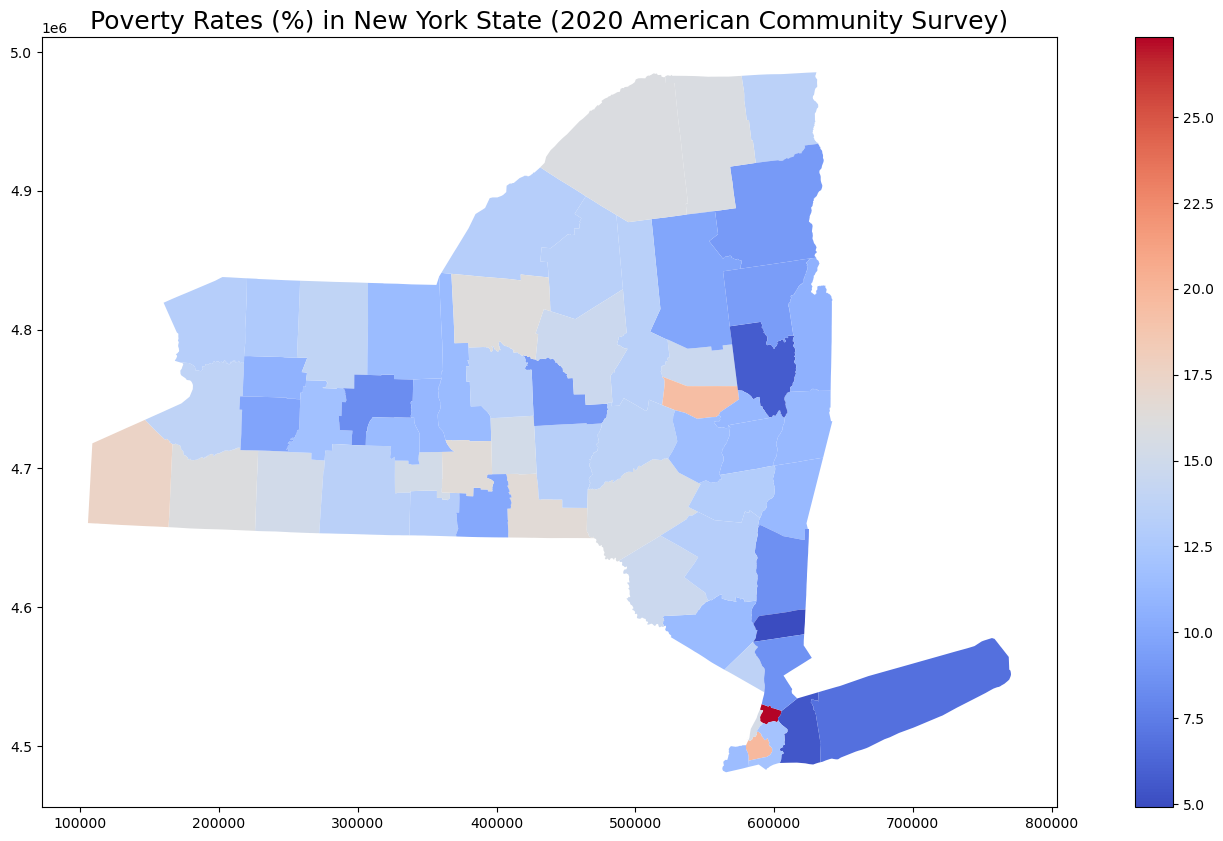

In [18]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

# Plot data
# Source: https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html
ny_poverty_county.plot(column = "Poverty_Rate",
                       ax = ax,
                       cmap = "coolwarm",
                       legend = True)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Poverty Rates (%) in New York State (2020 American Community Survey)', fontdict = {'fontsize': '18', 'fontweight' : '3'})

## Step 12: Write your data to a shapefile

Now that you've done all this great work, you will want to export it as a file.  We can use the <span style="color:red">gpd.to_file()</span> function for this.  I'll be using shapefiles (since this is the default output file format), but you can use export to a database/online repository as well, and change the file format to other compatible ones by typing in <span style="color:red">fiona.supported_drivers</span> into a code line.

First, you will want to create an output path to store your data if one does not exist.  If does exist, you will overwrite that directory.  Doing so is not automatic--you will need to set the parameter <span style="color:red">exist_ok = True</span> to suppress the error message and overwrite the directory.  NOTE: For simplicity, I just created a directory the old fashioned way.

Then, you will want to set up some error handling to make sure the file directory is created.  When an error(exception) occurs, Python will generate an error message and the program will crash.  We can handle these errors using the <span style="color:red">try</span> statement. This way, instead of the program crashing, the <span style="color:red">except</span> block will be executed.  You can define as many exception blocks as you'd like.  You can use <span style="color:red">else</span> to define code to be executed if no errors are raised.  Another good practice is to define a <span style="color:red">finally</span> block, which will be executed regardless of any error.  <span style="color:red">Finally</span> is often used to clean up resources and close objects when the script is done. 

After that, just write the file to the directory.  The variable <span style="color:red">ny_poverty_county</span> contains all the data we want to export, so we will replace "gpd" with "ny_poverty_county" to get <span style="color:red">ny_poverty_county.to_file</span>.  NOTE: I needed to use the <span style="color:red">encoding='utf-8'</span> parameter.  I've not seen this in all code samples, so be aware that you might need this as well.

You may be wondering what the text highlighted in pink is below.  Its not an error--its just a message warning you that the column names have been shortened because shapefiles only support 13 character field names.  If that is all you see, then that means your file has written successfully!

### <span style="color:green">Note: You will need to add a directory location to get this to work.  I've removed mine below.</span>

In [19]:
# Create a output path for the data
# Write data to shapefile

try:
    ny_poverty_county.to_file(r"\\Enter your directory and shapefile location here", encoding='utf-8')
    print("File successfully written to directory")
except OSError as error:
    print ("File cannot be written to directory")


C:\Users\mromano1\AppData\Local\Temp\ipykernel_30684\380519530.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ny_poverty_county.to_file(r"\\dotfp\40Worth_DatafilesII\Administrative_Guide\PMA\Maddalena Romano\Census API Equity Analysis\Poverty Rates in NYS 2019 v3.shp", encoding='utf-8')


File successfully written to directory


# Thanks for giving me the opportunity to teach you all!  I hope you enjoyed it!